In [24]:
import sys
sys.path.append('/tf/main/ds4se/notebooks/code2vec/code2vec')

from typing import *
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Disable GPU
#tf.config.set_visible_devices([], 'GPU')

In [ ]:
config = {
    'code2vec_model_path': '/tf/main/ds4se/dvc-ds4se/models/cv/java-large-release/saved_model_iter3.release',
    'code2vec_predicter': {
        'SHOW_TOP_CONTEXTS': 10,
        'MAX_PATH_LENGTH': 8,
        'MAX_PATH_WIDTH': 2,
        'JAR_PATH': 'JavaExtractor/JPredict/target/JavaExtractor-0.0.1-SNAPSHOT.jar',
    },
    'codesearchnet_java_csv_path': '/tf/main/ds4se/dvc-ds4se/code/searchnet/[codesearchnet-java-1597073966.81902].csv',
    'spm_model_path': '/tf/main/my_model/spm',
    'spm_vocab_size': 16384,
    'spm_sentence_length': 256,
    'ae_checkpoint_path': '/tf/main/my_model/ae_checkpoint',
    'ae_embedding_dim': 256,
    'ae_gru_units': 512,
    'ae_batch_size': 16,
}

## Load CodeSearchNet-Java

In [ ]:
import pandas as pd

df_searchnet = pd.read_csv(config['codesearchnet_java_csv_path'], header=0, index_col=0, sep='~')

In [ ]:
len(df_searchnet)

In [ ]:
df_searchnet.head(4)

## Running code2vec over CodeSearchNet-Java

In [ ]:
import code2vec
import common as code2vec_common
import config as code2vec_config
import extractor as code2vec_extrator

code2vec_cfg = code2vec_config.Config(set_defaults=True)
code2vec_cfg.PREDICT = True
code2vec_cfg.MODEL_LOAD_PATH = config['code2vec_model_path']
code2vec_cfg.DL_FRAMEWORK = 'tensorflow'
code2vec_cfg.EXPORT_CODE_VECTORS = True
code2vec_cfg.verify()

In [ ]:
code2vec_model = code2vec.load_model_dynamically(code2vec_cfg)
code2vec_path_extractor = code2vec_extrator.Extractor(
    code2vec_cfg,
    jar_path=config['code2vec_predicter']['JAR_PATH'],
    max_path_length=config['code2vec_predicter']['MAX_PATH_LENGTH'],
    max_path_width=config['code2vec_predicter']['MAX_PATH_WIDTH']
)

In [ ]:
import os
import tempfile
import numpy as np

def code2vec_predict(code: str) -> List[np.ndarray]:
    os.chdir('/tf/main/ds4se/notebooks/code2vec/code2vec')
    with tempfile.NamedTemporaryFile(mode='w', encoding='utf-8', suffix='.java') as input_file:
        input_file.write(code)
        input_file.flush()
        input_filename = input_file.name
        try:
            predict_lines, hash_to_string_dict = code2vec_path_extractor.extract_paths(input_filename)
        except ValueError as e:
            raise
    assert len(predict_lines) == 1
    raw_prediction_results = code2vec_model.predict(predict_lines)
    assert len(raw_prediction_results) == 1
    raw_prediction = raw_prediction_results[0]
    return raw_prediction.code_vector

In [ ]:
for i, row in df_searchnet.iterrows():
    if i == 4:
        break
    print('\n'.join(repr(code2vec_predict(row['code'])).split('\n')[:2]))

## Use google/sentencepiece for input tokenization

In [ ]:
! pip3 install --user -U sentencepiece

### Training

In [ ]:
import sentencepiece as spm

print("Training... (Use docker logs -f NAME to see the logs)", flush=True)
spm.SentencePieceTrainer.train(
    sentence_iterator=(i for i in df_searchnet['code']),
    max_sentence_length=config['spm_sentence_length'],
    model_prefix=config['spm_model_path'],
    model_type='bpe',
    vocab_size=config['spm_vocab_size']
)
print('Finished.')

### Load the model

In [6]:
import sentencepiece as spm

spm_model = spm.SentencePieceProcessor(model_file=config['spm_model_path'] + '.model')

In [7]:
print(spm_model.encode(df_searchnet['code'].iloc[0], out_type='str', add_bos=True, add_eos=True))
print(spm_model.encode(df_searchnet['code'].iloc[0], add_bos=True, add_eos=True))

['<s>', '▁protected', '▁final', '▁void', '▁fast', 'Path', 'Ordered', 'Emit', '(', 'U', '▁value', ',', '▁boolean', '▁delay', 'Error', ',', '▁Disposable', '▁dis', 'posable', ')', '▁{', '▁final', '▁O', 'bserver', '<?', '▁super', '▁V', '>', '▁observer', '▁=', '▁downstream', ';', '▁final', '▁Simple', 'Plain', 'Queue', '<', 'U', '>', '▁q', '▁=', '▁queue', ';', '▁if', '▁(', 'w', 'ip', '.', 'get', '()', '▁==', '▁0', '▁&&', '▁w', 'ip', '.', 'compareAndSet', '(0,', '▁1))', '▁{', '▁if', '▁(', 'q', '.', 'isEmpty', '())', '▁{', '▁accept', '(', 'observer', ',', '▁value', ');', '▁if', '▁(', 'le', 'ave', '(', '-1)', '▁==', '▁0)', '▁{', '▁return', ';', '▁}', '▁}', '▁else', '▁{', '▁q', '.', 'offer', '(', 'value', ');', '▁}', '▁}', '▁else', '▁{', '▁q', '.', 'offer', '(', 'value', ');', '▁if', '▁(!', 'enter', '())', '▁{', '▁return', ';', '▁}', '▁}', '▁Queue', 'Dr', 'ain', 'Helper', '.', 'dr', 'ain', 'Loop', '(', 'q', ',', '▁observer', ',', '▁delay', 'Error', ',', '▁dis', 'posable', ',', '▁this', ');', '▁}

In [8]:
spm_model.vocab_size()

16384

### Preprocess

In [9]:
import itertools

def encode_and_pad(s: str) -> tf.Tensor:
    return tf.convert_to_tensor(
        tf.keras.preprocessing.sequence.pad_sequences([
            spm_model.encode(s, add_bos=True, add_eos=True)
        ], maxlen=config['spm_sentence_length'], padding='post')[0],
        dtype=tf.int32
    )

df_searchnet_tf_slices = []
for i, row in enumerate(df_searchnet['code']):
    df_searchnet_tf_slices.append(encode_and_pad(row))
    if (i % 10000) == 0:
        print(i)
        
df_searchnet_tf = tf.data.Dataset.from_tensor_slices(df_searchnet_tf_slices).shuffle(len(df_searchnet_tf_slices))
df_searchnet_tf = df_searchnet_tf.batch(config['ae_batch_size'], drop_remainder=True)
del df_searchnet_tf_slices

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000


In [10]:
df_searchnet_tf

<BatchDataset shapes: (16, 256), types: tf.int32>

### Autoencoder

In [11]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))


class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights


optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([1] * config['ae_batch_size'], 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [12]:
encoder = Encoder(
    spm_model.vocab_size(),
    config['ae_embedding_dim'],
    config['ae_gru_units'],
    config['ae_batch_size'])
decoder = Decoder(
    spm_model.vocab_size(),
    config['ae_embedding_dim'],
    config['ae_gru_units'],
    config['ae_batch_size'])
checkpoint_prefix = config['ae_checkpoint_path']
checkpoint = tf.train.Checkpoint(
    optimizer=optimizer,
    encoder=encoder,
    decoder=decoder)

In [13]:
# sample input
example_input_batch = next(iter(df_searchnet_tf))
example_input_batch.shape

sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print('Encoder output shape: (batch size, sequence length, units)', sample_output.shape)
print('Encoder Hidden state shape: (batch size, units)', sample_hidden.shape)

sample_decoder_output, _, _ = decoder(tf.random.uniform((config['ae_batch_size'], 1)),
                                      sample_hidden, sample_output)
print('Decoder output shape: (batch_size, vocab size)', sample_decoder_output.shape)

Encoder output shape: (batch size, sequence length, units) (16, 256, 512)
Encoder Hidden state shape: (batch size, units) (16, 512)
Decoder output shape: (batch_size, vocab size) (16, 16384)


In [33]:
import time

EPOCHS = 100
steps_per_epoch = config['spm_sentence_length']//config['ae_batch_size']

try:
    last_epoch, next_epoch = next_epoch, next_epoch + EPOCHS
except NameError:
    last_epoch, next_epoch = 0, EPOCHS

for epoch in range(last_epoch, next_epoch):
    last_epoch, next_epoch = epoch, epoch + EPOCHS
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, inp) in enumerate(df_searchnet_tf.take(config['ae_batch_size'])):
        batch_loss = train_step(inp, inp, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 11 Batch 0 Loss 3.4093
Epoch 11 Loss 2.9281
Time taken for 1 epoch 10.301083326339722 sec

Epoch 12 Batch 0 Loss 2.0970
Epoch 12 Loss 2.8734
Time taken for 1 epoch 12.733031988143921 sec

Epoch 13 Batch 0 Loss 2.3155
Epoch 13 Loss 2.8661
Time taken for 1 epoch 10.144303798675537 sec

Epoch 14 Batch 0 Loss 2.8506
Epoch 14 Loss 2.8460
Time taken for 1 epoch 12.816287755966187 sec

Epoch 15 Batch 0 Loss 3.2263
Epoch 15 Loss 2.6453
Time taken for 1 epoch 10.219453573226929 sec

Epoch 16 Batch 0 Loss 1.9718
Epoch 16 Loss 2.8500
Time taken for 1 epoch 12.908640384674072 sec

Epoch 17 Batch 0 Loss 2.1083
Epoch 17 Loss 2.5592
Time taken for 1 epoch 10.16498327255249 sec

Epoch 18 Batch 0 Loss 2.1226
Epoch 18 Loss 2.7514
Time taken for 1 epoch 12.843602657318115 sec

Epoch 19 Batch 0 Loss 2.9761
Epoch 19 Loss 2.5865
Time taken for 1 epoch 10.251368284225464 sec

Epoch 20 Batch 0 Loss 2.6886
Epoch 20 Loss 2.7747
Time taken for 1 epoch 12.860767602920532 sec

Epoch 21 Batch 0 Loss 3.1552
Ep

### Evaluation

In [39]:
def evaluate(sentence: str):
    attention_plot = np.zeros((config['spm_sentence_length'], config['spm_sentence_length']))

    inputs = tf.expand_dims(encode_and_pad(sentence), axis=0)

    result = [1]

    hidden = [tf.zeros((1, config['ae_gru_units']))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([1], axis=0)

    for t in range(config['spm_sentence_length']):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(int(predicted_id))
        if predicted_id == 2:
            break

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], axis=0)

    result_sentence = spm_model.decode(result)
    return result_sentence, sentence, attention_plot

In [40]:
evaluate(df_searchnet['code'].iloc[0])

('protected boolean is> get(final String> result = new ArrayList<String> result = new ArrayList<String> result = new ArrayList<String> result = new ArrayList<String> result = new ArrayList<String> result = new ArrayList<String> result = new ArrayList<String> result = new ArrayList<String> result = new ArrayList<String> result = new ArrayList<String> result = new ArrayList<String> result = new ArrayList<String> result = new ArrayList<String> result = new ArrayList<String> result = new ArrayList<String> result = new ArrayList<String> result = new ArrayList<String> result = new ArrayList<String> result = new ArrayList<String> result = new ArrayList<String> result = new ArrayList<String> result = new ArrayList<String> result = new ArrayList<String> result = new ArrayList<String> result = new ArrayList<String> result = new ArrayList<String> result = new ArrayList<String> result = new ArrayList<String> result = new ArrayList<String> result = new ArrayList<String> result = new ArrayList<Strin

In [41]:
evaluate(df_searchnet['code'].iloc[42])

('@Override public List<T> map.get(final String> map.get(final String> map.get(final String> map.get(final String> map.get(final String> map.get(final String> map.get(final String> map.get(final String> map.get(final String> map.get(final String> map.get(final String> map.get(final String> map.get(final String> map.get(final String> map.get(final String> map.get(final String> map.get(final String> map.get(final String> map.get(final String> map.get(final String> map.get(final String> map.get(final String> map.get(final String> map.get(final String> map.get(final String> map.get(final String> map.get(final String> map.get(final String> map.get(final String> map.get(final String> map.get(final String> map.get(final String> map.get(final String> map.get(final String> map.get(final String> map.get(',
 '@CheckReturnValue\n    @SchedulerSupport(SchedulerSupport.NONE)\n    public static <T, D> Observable<T> using(Callable<? extends D> resourceSupplier, Function<? super D, ? extends Observable

In [42]:
def plot_attention(attention):
    import matplotlib.ticker

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}
    plt.show()

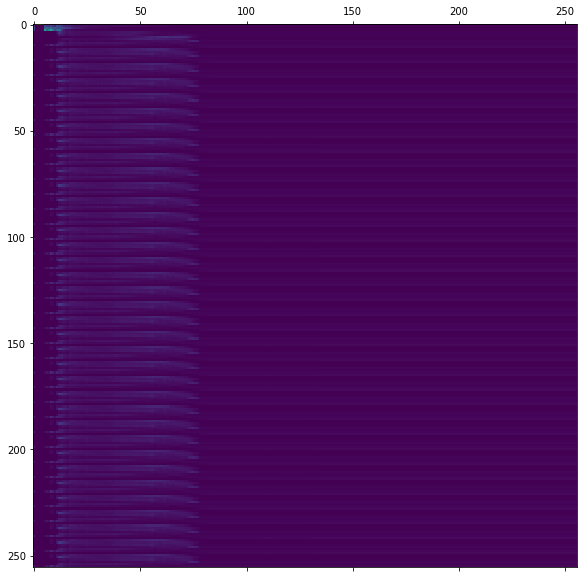

In [46]:
plot_attention(evaluate(df_searchnet['code'].iloc[42])[2])